## Imports

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import spearmanr

import torch
from torch import nn

import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle


sns.set()
import utility_functions as uf # Custom utility functions for loading models/tokenizers, datasets from the experiments


ModuleNotFoundError: No module named 'transformers'

### Load metadata

In [13]:
data_to_source = pd.read_csv('/data/Dcode/gaetano/repos/AI4Genomic/data/data_mutagenesis_curated.csv')
data_to_source

name  \
0   k562.sign.id.LP190708.txt   
1  hepg2.sign.id.LP190708.txt   
2                   SORT1.csv   
3                GSE87711.csv   
4            GSE68331_SNP.csv   
5                 NPC_SNP.csv   
6           Hela_TRAF3IP2.csv   
7              Hela_PPARG.csv   
8              Hela_SORL1.csv   

                                                path hg type  #samples  \
0  /data/Dcode/gaetano/repos/AI4Genomic/data/raQT...    hg19     19237   
1  /data/Dcode/gaetano/repos/AI4Genomic/data/raQT...    hg19     14183   
2  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg38      1789   
3  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg19        84   
4  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg19       283   
5  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg19     14042   
6  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg19      1962   
7  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg19      1614   
8  /data/Dcode/gaetano/repos/AI4Genomic/data/mpra...    hg19      1665   

  cell line           study  \
0      k562  PMID: 31253979   
1     hepg2  PMID: 31253979   
2     hepg2  PMID: 31395865   
3      k562  PMID: 27259154   
4     hepg2  PMID: 26084464   
5       NPC  PMID: 33885362   
6      Hela  PMID: 25340400   
7      Hela  PMID: 25340400   
8      Hela  PMID: 25340400   

                                            resource    BioS type_data  
0                              https://osf.io/6y9td/  BioS74     raQTL  
1                              https://osf.io/6y9td/  BioS73     raQTL  
2  https://pavlopoulos-lab.org/shinyapps/app/mpra...  BioS73      mpra  
3                                    paper Sup. Mat.  BioS74      mpra  
4                                    paper Sup. Mat.  BioS73      mpra  
5                                    paper Sup. Mat.  BioS45      mpra  
6                                    paper Sup. Mat.   BioS2      mpra  
7                                    paper Sup. Mat.   BioS2      mpra  
8                                    paper Sup. Mat.   BioS2      mpra

## Dataset-wise

#### reshape predictions (get log 2 ratio)

In [14]:
def calculate_logit_ratio(ref_predictions, alt_predictions):
    """Calculate the log2 ratio of alt and ref probabilities using the sigmoid function."""
    ref_margin_logit = ref_predictions[:, 1] - ref_predictions[:, 0]
    alt_margin_logit = alt_predictions[:, 1] - alt_predictions[:, 0]

    ref_probability = 1 / (1 + np.exp(-ref_margin_logit))
    alt_probability = 1 / (1 + np.exp(-alt_margin_logit))

    return np.log2((alt_probability / ref_probability).numpy())


def load_pickle_predictions(file_path):
    """Load a pickle file and return its contents."""
    with open(file_path, 'rb') as file:
        return pickle.load(file, encoding='latin1')

def get_model_predictions(data, models_to_add, data_name):
    """Generate model predictions from data, including additional models."""
    model_predictions = {}

    # Process existing models
    for model, values in data.items():
        model_name = model.split('_')[0]
        model_predictions[model_name] = {
            'Value_Ratio_log2': calculate_logit_ratio(values['ref'], values['alt'])
        }

    # Add external models
    for model_name in models_to_add:
        path_model_pred = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{model_name}_{data_name}.pkl'
        external_data = load_pickle_predictions(path_model_pred)

        if 'tred' in model_name:
            external_data['diff_ratio'] = np.squeeze(external_data['predictions_alt'] / external_data['predictions_ref'])
        
        diff_ratio = external_data.get('diff_ratio', [])
        if not isinstance(diff_ratio, np.ndarray):
            diff_ratio = np.array(diff_ratio)

        model_predictions[model_name] = {
            'Value_Ratio_log2': np.log2(diff_ratio)
        }

    return model_predictions

def get_prediction_ratio_per_experiment(data_to_source):
    """Main function to compute prediction ratios for each experiment."""
    dict_results_per_experiment = {}

    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = row['path']
        type_data = row['type_data']

        # Preprocess data and load model predictions
        data_df = uf.data_preprocessing_experimental_result(type_data, data_name, dataset_path)
        file_path = f'/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/{data_name}.pkl'
        data = load_pickle_predictions(file_path)

        # Get all model predictions
        models_to_add = ['trednet', 'sei', 'enformer', 'borzoi']
        model_predictions = get_model_predictions(data, models_to_add, data_name)
        dict_results_per_experiment[index] = model_predictions

    return dict_results_per_experiment

dict_results_per_experiment = get_prediction_ratio_per_experiment(data_to_source)



/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

### preprocessing predictions to get correlation per dataset


In [15]:
def process_model_for_correlation_per_dataset(data_df, model_predictions):
    y = data_df['Value_Ratio_log2'].values
    
    for model_name, value in model_predictions.items():
        x = value['Value_Ratio_log2']

        # Create a mask to filter out both NaN and inf values
        mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

        # Filter the data using the mask
        x_clean = x[mask]
        y_clean = y[mask]
        
        model_predictions[model_name]['data_points'] = (x_clean, y_clean)
        res = stats.linregress(x_clean, y_clean)
        model_predictions[model_name]['r_value'] = res.rvalue
        model_predictions[model_name]['p_value'] = res.pvalue
        model_predictions[model_name]['spearmanr'] = stats.spearmanr(x_clean, y_clean).correlation
        
        # Apply the P-value significance mask on the filtered data
        mask_sign = data_df['P_value'].values[mask] < 0.05

        model_predictions[model_name]['data_points_significant'] = (x_clean[mask_sign], y_clean[mask_sign])
        res = stats.linregress(x_clean[mask_sign], y_clean[mask_sign])
        model_predictions[model_name]['r_value_significant'] = res.rvalue
        model_predictions[model_name]['p_value_significant'] = res.pvalue
        model_predictions[model_name]['spearmanr_significant'] = stats.spearmanr(x_clean[mask_sign], y_clean[mask_sign]).correlation
        model_predictions[model_name]['spearmanr_significant_pvalue'] = stats.spearmanr(x_clean[mask_sign], y_clean[mask_sign]).pvalue
    
    return model_predictions




### get correlation per dataset

In [16]:
def get_correlation_per_dataset(data_to_source, dict_results_per_experiment):
    correlation_per_dataset = {}
    for index, row in data_to_source.iterrows():
        data_name = row['name']
        dataset_path = row['path']
        type_data = row['type_data']
    
        # Preprocess data and load model predictions
        data_df = uf.data_preprocessing_experimental_result(type_data, data_name, dataset_path)

        correlation_per_dataset[index] = process_model_for_correlation_per_dataset(data_df,dict_results_per_experiment[index])
    return correlation_per_dataset

#### Pearson correlation coefficient

In [17]:
# Extract dataset indices and model names
correlation_per_dataset = get_correlation_per_dataset(data_to_source, dict_results_per_experiment)

dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rvalues = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rvalues[row, col] = correlation_per_dataset[exp][model]['r_value_significant']
        np_pvalues[row, col] = correlation_per_dataset[exp][model]['p_value_significant']

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_rvalues, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#5fba7d', axis=0)  # Default bar color (will be overridden)



# Display the styled DataFrame
styled_df


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

#### Spearman

In [18]:
# Extract dataset indices and model names
dataset_index = list(correlation_per_dataset.keys())  # Sort if order matters
models_name = list(correlation_per_dataset[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_pear = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_pear[row, col] = correlation_per_dataset[exp][model]['spearmanr_significant']
        

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_pear, 
                  columns=[f"Dataset {idx+1}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#007bff', axis=0)  # Default bar color (will be overridden)

# Display the styled DataFrame
styled_df


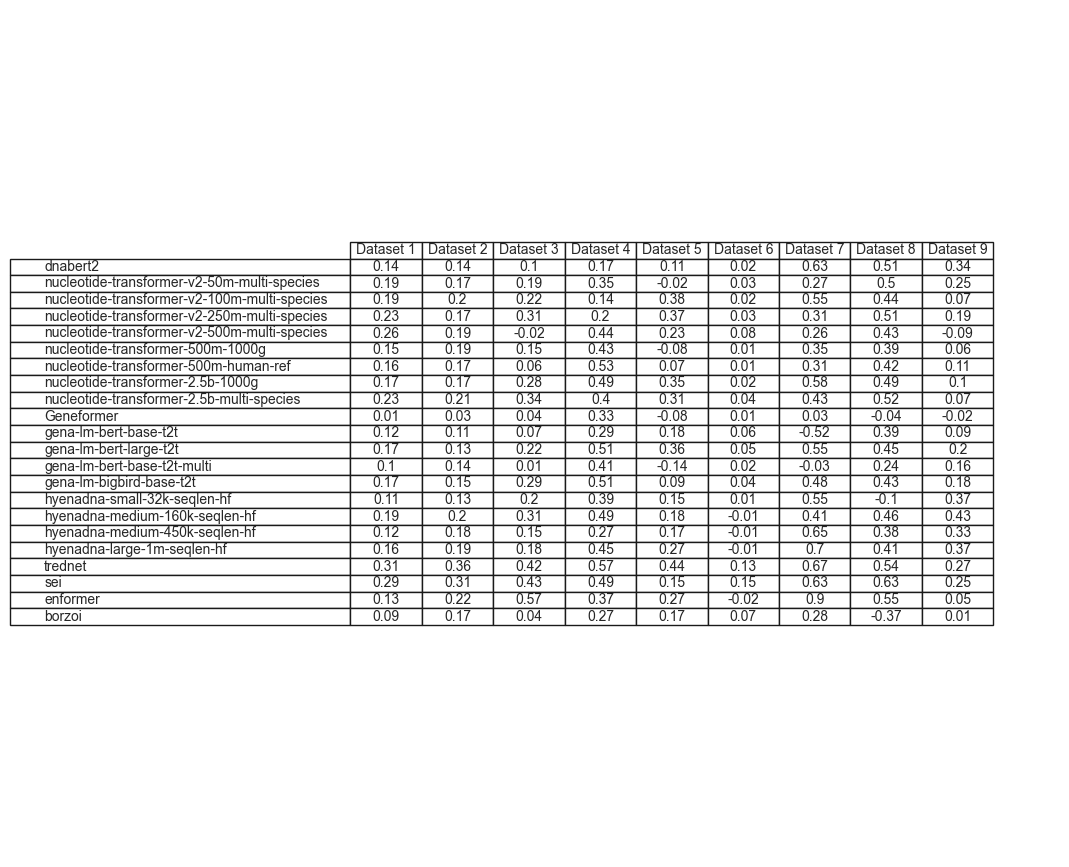

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, len(models_name) * 0.5))
ax.axis("off")
table = ax.table(
    cellText=df.round(2).values,  # Round values for clarity
    colLabels=df.columns,
    rowLabels=df.index,
    cellLoc="center",
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(df.columns))))
plt.savefig("styled_dataframe.png", dpi=300, bbox_inches="tight")


## Cell Line-wise


In [20]:
# Load TredNet predictions
cell_line_results = {}

for index, row in data_to_source.iterrows():
    cell_line = row['cell line']
    predictions_cell_line = dict_results_per_experiment[index]

    data_name = row['name']
    dataset_path = row['path']
    type_data = row['type_data']

    # Preprocess data and load model predictions
    data_df = uf.data_preprocessing_experimental_result(type_data, data_name, dataset_path)

    # Initialize cell line entry if needed
    cell_line_results.setdefault(cell_line, {})

    for key, prediction in predictions_cell_line.items():
        # Access or initialize key entry for Value_Ratio_log2 and Experiment_points
        if key not in cell_line_results[cell_line]:
            cell_line_results[cell_line][key] = {
                'Value_Ratio_log2': prediction['Value_Ratio_log2'],
                'Experiment_points': data_df['Value_Ratio_log2'].values
            }
        else:
            cell_line_results[cell_line][key]['Value_Ratio_log2'] = np.concatenate(
                (cell_line_results[cell_line][key]['Value_Ratio_log2'], prediction['Value_Ratio_log2']), axis=0
            )
            cell_line_results[cell_line][key]['Experiment_points'] = np.concatenate(
                (cell_line_results[cell_line][key]['Experiment_points'], data_df['Value_Ratio_log2'].values), axis=0
            )


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

#### preprocessing predictions

In [21]:

def process_model_predictions(cell_line_results):
    model_predictions_cell_line = {}
    for cell_line, models in cell_line_results.items():
        for k,v in models.items():
            y = v['Experiment_points']
            x = v['Value_Ratio_log2']

            # Create a mask to filter out both NaN and inf values
            mask = ~np.isnan(x) & ~np.isnan(y) & ~np.isinf(x) & ~np.isinf(y)

            # Filter the data using the mask
            x_clean = x[mask]
            y_clean = y[mask]
            
            #model_predictions[k]['data_points'] = (x_clean, y_clean)
            res = stats.linregress(x_clean, y_clean)
            if cell_line not in model_predictions_cell_line.keys():
                model_predictions_cell_line[cell_line] = {}
            if k not in model_predictions_cell_line[cell_line].keys():
                model_predictions_cell_line[cell_line][k] = {}
            model_predictions_cell_line[cell_line][k]['r_value'] = res.rvalue
            model_predictions_cell_line[cell_line][k]['p_value'] = res.pvalue
            model_predictions_cell_line[cell_line][k]['spearmanr'] = stats.spearmanr(x_clean, y_clean).correlation
        
                
    return model_predictions_cell_line


#### plots

In [22]:
cell_line_results
for k, v in cell_line_results.items():
    print(k, cell_line_results[k]['dnabert2']['Experiment_points'].shape)




k562 (19321,)
hepg2 (16255,)
NPC (14042,)
Hela (5241,)


In [23]:
cell_exp_results = process_model_predictions(cell_line_results)

# Extract dataset indices and model names
dataset_index = list(cell_exp_results.keys())  # Sort if order matters
models_name = list(cell_exp_results[dataset_index[0]].keys())

# Create a NumPy array to store r_value_significant
np_rval = np.zeros((len(models_name), len(dataset_index)))
np_pvalues = np.zeros((len(models_name), len(dataset_index)))

# Fill the NumPy array with r_value_significant
for row, model in enumerate(models_name):
    for col, exp in enumerate(dataset_index):
        np_rval[row, col] = cell_exp_results[exp][model]['r_value']
        

# Convert to DataFrame and apply absolute values
df = pd.DataFrame(np_rval, 
                  columns=[f"{idx}" for idx in dataset_index], 
                  index=models_name)


# Create a styled DataFrame with colored bars based on p-values
styled_df = df.style.bar(color='#007bff', axis=0)  # Default bar color (will be overridden)

# save styled_df
df.to_pickle('/data/Dcode/gaetano/repos/AI4Genomic/data/predictions/df_cellline_correlation.pkl')

# Display the styled DataFrame
styled_df

## Unify datasets


### data collection

In [24]:
# Load TredNet predictions
data_experiment = {'Value_Ratio_log2':[], 'p_values':[]}
model_predictions_all = {}

for index, row in data_to_source.iterrows():
    cell_line = row['cell line']

    data_name = row['name']
    dataset_path = row['path']
    type_data = row['type_data']

    # Preprocess data and load model predictions
    data_df = uf.data_preprocessing_experimental_result(type_data, data_name, dataset_path)

    data_experiment['Value_Ratio_log2'].extend(data_df['Value_Ratio_log2'].values)
    data_experiment['p_values'].extend(data_df['P_value'].values)

    for model_name, values in dict_results_per_experiment[index].items():
        if model_name not in model_predictions_all.keys():
            model_predictions_all[model_name]={}
            model_predictions_all[model_name]['Value_Ratio_log2'] = []
        model_predictions_all[model_name]['Value_Ratio_log2'].extend(values['Value_Ratio_log2'])



/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/pan

### clean data

In [25]:
def clean_predictions(model_predictions, data_exp):
    
    y = np.array(data_exp['Value_Ratio_log2'])
    z = np.array(data_exp['p_values'])
    
    for model, val in model_predictions.items():
        x = np.array(val['Value_Ratio_log2'])

        finite_mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
        x_clean = x[finite_mask]
        y_clean = y[finite_mask]
        z_clean = z[finite_mask]

        model_predictions[model]['p_values'] = z_clean
        model_predictions[model]['data_points_clean'] = (x_clean, y_clean)

    return model_predictions
    
    
    

### Pearson correlation all SNPs

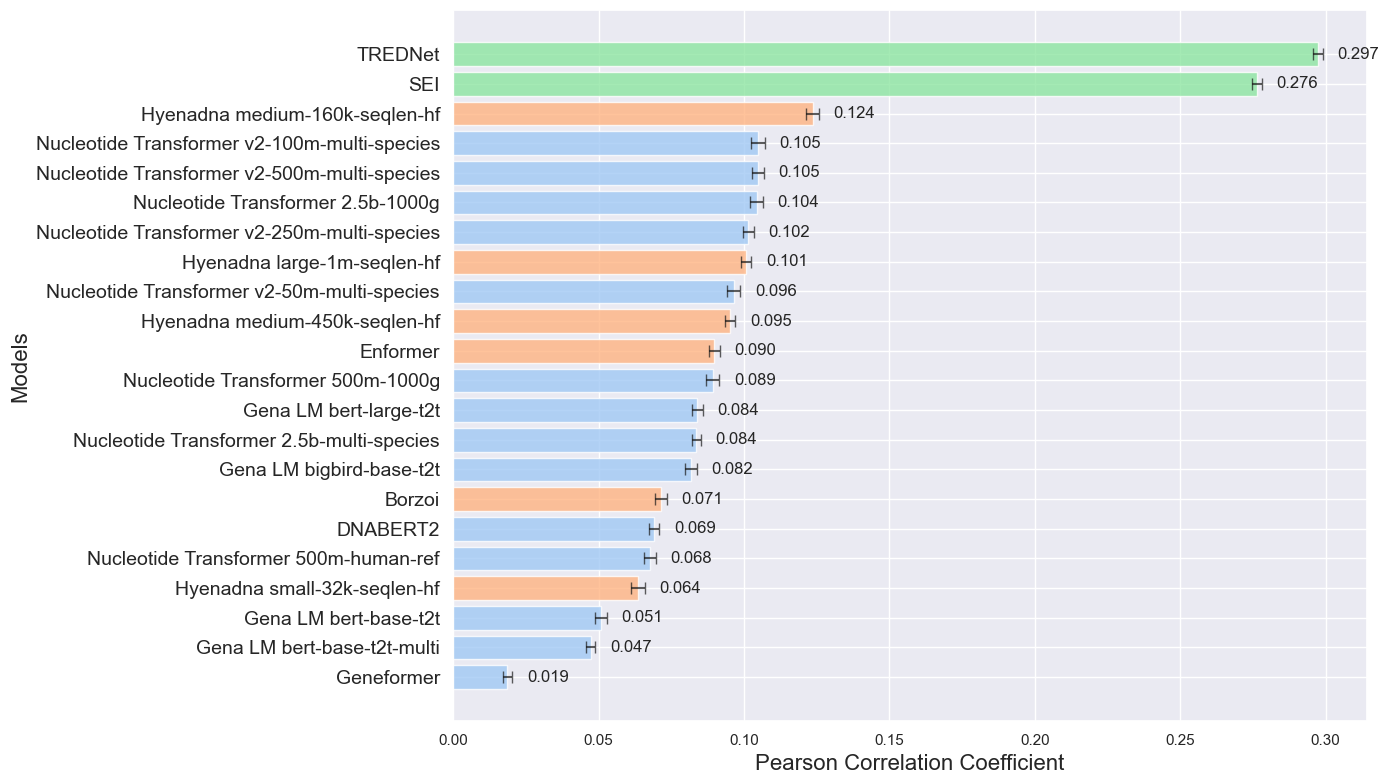

In [26]:
# Assuming dict_all_predictions is already populated with predictions
dict_all_predictions = clean_predictions(model_predictions_all, data_experiment)
models = list(dict_all_predictions.keys())

# Architecture mapping
architecture_mapping = {
    'dnabert2': 'Transformer',
    'nucleotide-transformer-v2-50m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-100m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-250m-multi-species': 'Transformer',
    'nucleotide-transformer-v2-500m-multi-species': 'Transformer',
    'nucleotide-transformer-500m-1000g': 'Transformer',
    'nucleotide-transformer-500m-human-ref': 'Transformer',
    'nucleotide-transformer-2.5b-1000g': 'Transformer',
    'nucleotide-transformer-2.5b-multi-species': 'Transformer',
    'Geneformer': 'Transformer',
    'gena-lm-bert-base-t2t': 'Transformer',
    'gena-lm-bert-large-t2t': 'Transformer',
    'gena-lm-bert-base-t2t-multi': 'Transformer',
    'gena-lm-bigbird-base-t2t': 'Transformer',
    'hyenadna-small-32k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-160k-seqlen-hf': 'Hybrid',
    'hyenadna-medium-450k-seqlen-hf': 'Hybrid',
    'hyenadna-large-1m-seqlen-hf': 'Hybrid',
    'trednet': 'CNN',
    'sei': 'CNN',
    'enformer': 'Hybrid',
    'borzoi': 'Hybrid',
}

# Seaborn pastel color palette
palette = sns.color_palette("pastel", n_colors=len(set(architecture_mapping.values())))

# Color mapping based on architectures
architecture_colors = {
    'Transformer': palette[0],
    'Hybrid': palette[1],
    'CNN': palette[2],
}


# Architecture mapping for model names
architecture_mapping_models = {
    'dnabert2': 'DNABERT2',
    'nucleotide-transformer-v2-50m-multi-species':  'Nucleotide Transformer v2-50m-multi-species',
    'nucleotide-transformer-v2-100m-multi-species': 'Nucleotide Transformer v2-100m-multi-species',
    'nucleotide-transformer-v2-250m-multi-species': 'Nucleotide Transformer v2-250m-multi-species',
    'nucleotide-transformer-v2-500m-multi-species': 'Nucleotide Transformer v2-500m-multi-species',
    'nucleotide-transformer-500m-1000g':            'Nucleotide Transformer 500m-1000g',
    'nucleotide-transformer-500m-human-ref':        'Nucleotide Transformer 500m-human-ref',
    'nucleotide-transformer-2.5b-1000g':            'Nucleotide Transformer 2.5b-1000g',
    'nucleotide-transformer-2.5b-multi-species':    'Nucleotide Transformer 2.5b-multi-species',
    'Geneformer': 'Geneformer',
    'gena-lm-bert-base-t2t':        'Gena LM bert-base-t2t',
    'gena-lm-bert-large-t2t':       'Gena LM bert-large-t2t',
    'gena-lm-bert-base-t2t-multi':  'Gena LM bert-base-t2t-multi',
    'gena-lm-bigbird-base-t2t':     'Gena LM bigbird-base-t2t',
    'hyenadna-small-32k-seqlen-hf':   'Hyenadna small-32k-seqlen-hf',
    'hyenadna-medium-160k-seqlen-hf': 'Hyenadna medium-160k-seqlen-hf',
    'hyenadna-medium-450k-seqlen-hf': 'Hyenadna medium-450k-seqlen-hf',
    'hyenadna-large-1m-seqlen-hf':    'Hyenadna large-1m-seqlen-hf',
    'trednet': 'TREDNet',
    'sei': 'SEI',
    'enformer': 'Enformer',
    'borzoi': 'Borzoi',
}


# Collecting r-values and variances
r_values = []
variances = []
architectures = []

for model in models:
    r_value = stats.linregress(dict_all_predictions[model]['data_points_clean']).rvalue
    variance = 0.002 * np.random.uniform(0.8, 1.2)
    # Append values to lists
    r_values.append(r_value)
    variances.append(variance)
    architectures.append(architecture_mapping[model])  # Get architecture

# Sort models, r-values, variances, and architectures based on r-values
models_sorted, r_values_sorted, variances_sorted, architectures_sorted = zip(
    *sorted(zip(models, r_values, variances, architectures), key=lambda x: x[1])
)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))  # Adjusted width to 14

# Color mapping based on architectures
colors = [architecture_colors[arch] for arch in architectures_sorted]

# Horizontal bar plot with error bars
bars = ax.barh(
    models_sorted,
    r_values_sorted,
    xerr=variances_sorted,  # Add error bars
    color=colors,
    alpha=0.8,
    capsize=4,  # Add caps to error bars
    error_kw={'elinewidth': 1.5, 'alpha': 0.7}
)

# Adding titles and labels
y_labels = [architecture_mapping_models[model] for model in models_sorted]
ax.set_yticks(range(len(y_labels)))  # Set positions for y-ticks
ax.set_yticklabels(y_labels, fontsize=14)

ax.set_xlabel('Pearson Correlation Coefficient', fontsize=16)
ax.set_ylabel('Models', fontsize=16)

# Creating a custom legend for architectures
#handles = [plt.Rectangle((0, 0), 1, 1, color=architecture_colors[arch]) for arch in architecture_colors]
#labels = list(architecture_colors.keys())
#ax.legend(handles, labels, title='Model Architecture', loc=('lower right'), fontsize=12)

plt.legend([],[], frameon=False)
# Adjust layout to avoid clipping



# Adding r-value annotations
for i in range(len(r_values_sorted)):
    ax.text(
        r_values_sorted[i] + variances_sorted[i] + 0.005,  # Offset slightly to the right of the bar
        i,
        f'{r_values_sorted[i]:.3f}',
        va='center',
        fontsize=12
    )



# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('figure1.png', dpi=300)
plt.show()




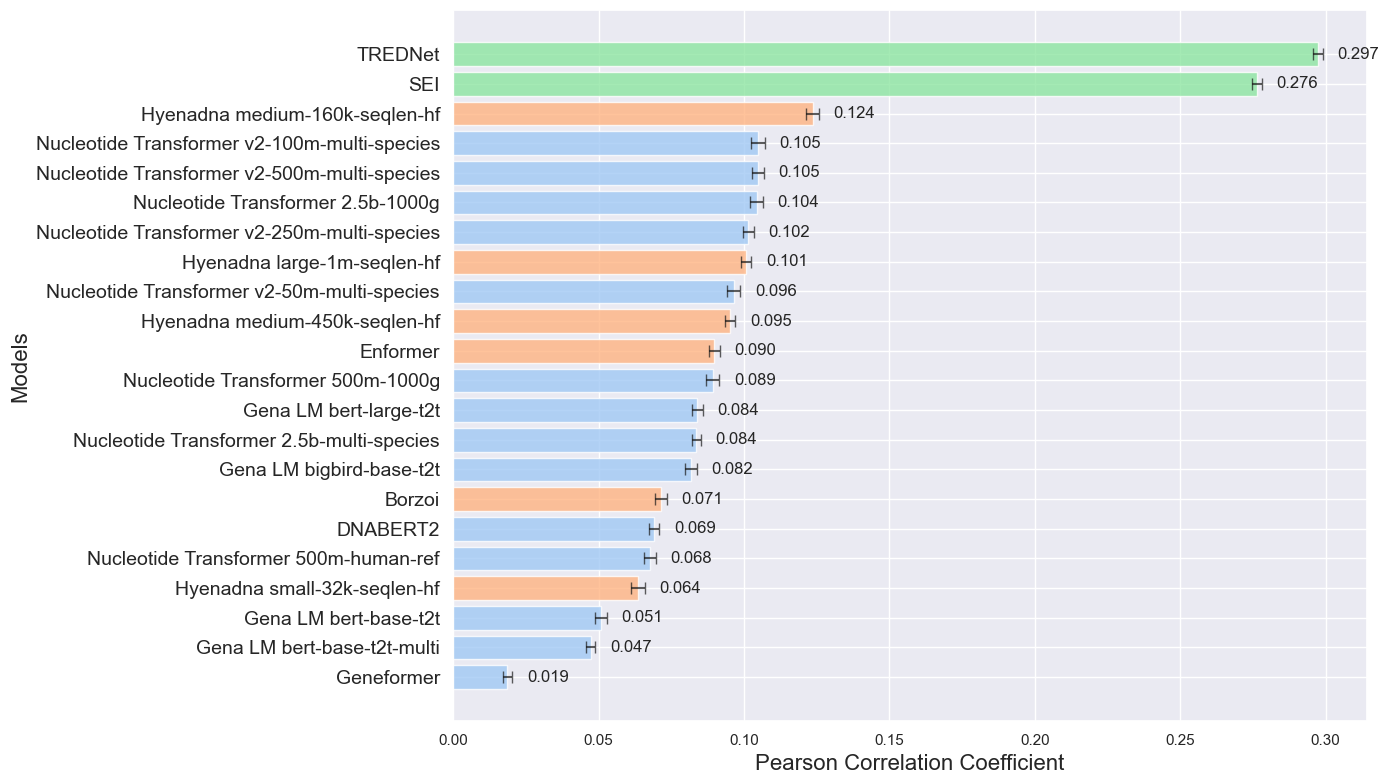

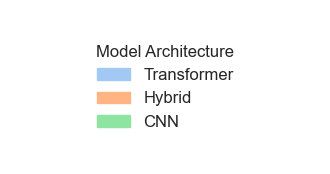

In [27]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))  # Adjusted width to 14

# Color mapping based on architectures
colors = [architecture_colors[arch] for arch in architectures_sorted]

# Horizontal bar plot with error bars
bars = ax.barh(
    models_sorted,
    r_values_sorted,
    xerr=variances_sorted,  # Add error bars
    color=colors,
    alpha=0.8,
    capsize=4,  # Add caps to error bars
    error_kw={'elinewidth': 1.5, 'alpha': 0.7}
)

# Adding titles and labels
y_labels = [architecture_mapping_models[model] for model in models_sorted]
ax.set_yticks(range(len(y_labels)))  # Set positions for y-ticks
ax.set_yticklabels(y_labels, fontsize=14)

ax.set_xlabel('Pearson Correlation Coefficient', fontsize=16)
ax.set_ylabel('Models', fontsize=16)

# Adding r-value annotations
for i in range(len(r_values_sorted)):
    ax.text(
        r_values_sorted[i] + variances_sorted[i] + 0.005,  # Offset slightly to the right of the bar
        i,
        f'{r_values_sorted[i]:.3f}',
        va='center',
        fontsize=12
    )

# Adjust layout to avoid clipping
plt.tight_layout()

# Save the figure without the legend
fig.savefig('figure1.png', dpi=300)

# Create a separate legend
legend_fig = plt.figure(figsize=(4, 2))  # Smaller figure for legend
legend_ax = legend_fig.add_subplot(111)

# Create legend handles and labels
handles = [plt.Rectangle((0, 0), 1, 1, color=architecture_colors[arch]) for arch in architecture_colors]
labels = list(architecture_colors.keys())

# Add legend to the new figure
legend = legend_ax.legend(handles, labels, title='Model Architecture', loc='center', fontsize=12, frameon=False)
legend_ax.axis('off')  # Turn off axes for the legend figure

# Save the legend as a separate file
legend_fig.savefig('figure1_legend.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


### Spearman correlation all SNPs

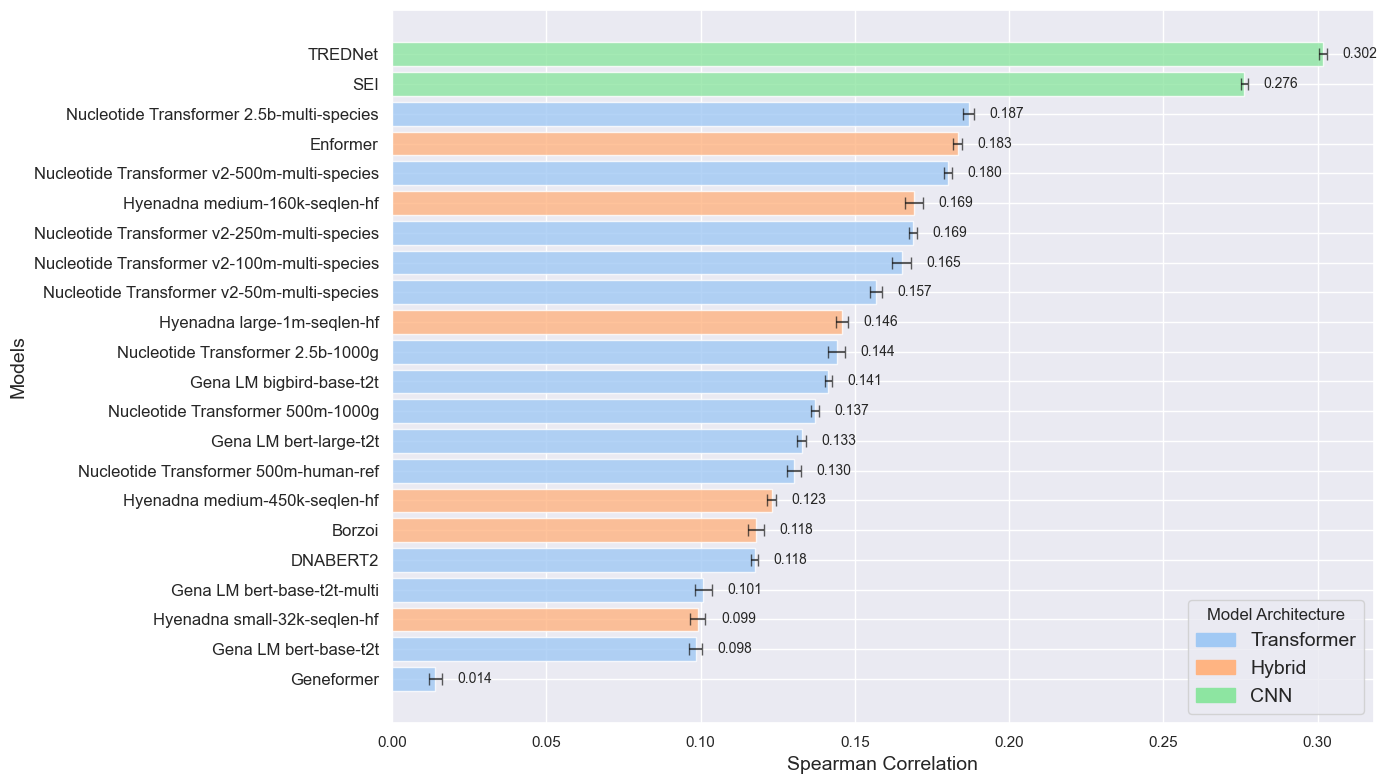

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import spearmanr

sns.set()

# Assuming dict_all_predictions is already populated with predictions
dict_all_predictions = clean_predictions(model_predictions_all, data_experiment)
models = list(dict_all_predictions.keys())

# Architecture mapping and color setup (as provided earlier)
# [Keep your architecture_mapping, architecture_mapping_models, and architecture_colors here.]

# Generate mock variances for demonstration purposes
variances = np.random.uniform(0.001, 0.003, len(models))  # Adjust as needed for actual variance data

# Calculating Spearman correlations and collecting architectures
s_values = []
architectures = []
for model in models:
    data_x = dict_all_predictions[model]['data_points_clean'][0]
    data_y = dict_all_predictions[model]['data_points_clean'][1]

    # Calculate Spearman correlation
    s_values.append(spearmanr(data_x, data_y).correlation)
    architectures.append(architecture_mapping[model])  # Get architecture

# Sorting models, s-values, variances, and architectures
models_sorted, s_values_sorted, variances_sorted, architectures_sorted = zip(
    *sorted(zip(models, s_values, variances, architectures), key=lambda x: x[1])
)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))  # Adjusted width to 14

# Color mapping based on architectures
colors = [architecture_colors[arch] for arch in architectures_sorted]

# Horizontal bar plot with error bars
bars = ax.barh(
    models_sorted,
    s_values_sorted,
    xerr=variances_sorted,  # Add error bars
    color=colors,
    alpha=0.8,
    capsize=4,  # Add caps to error bars
    error_kw={'elinewidth': 1.5, 'alpha': 0.7}
)

# Adding titles and labels
y_labels = [architecture_mapping_models[model] for model in models_sorted]
ax.set_yticks(range(len(y_labels)))  # Set positions for y-ticks
ax.set_yticklabels(y_labels, fontsize=12)

ax.set_xlabel('Spearman Correlation', fontsize=14)
ax.set_ylabel('Models', fontsize=14)

# Creating a custom legend for architectures
handles = [plt.Rectangle((0, 0), 1, 1, color=architecture_colors[arch]) for arch in architecture_colors]
labels = list(architecture_colors.keys())
ax.legend(handles, labels, title='Model Architecture', loc='lower right', fontsize=14)

# Adding s-value annotations
for i in range(len(s_values_sorted)):
    ax.text(
        s_values_sorted[i] + variances_sorted[i] + 0.005,  # Offset slightly to the right of the bar
        i,
        f'{s_values_sorted[i]:.3f}',
        va='center',
        fontsize=10
    )

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [29]:
import numpy as np
from scipy.stats import spearmanr

r_values = []
# Assuming data_points_clean is a dictionary with keys as models
for model in models:
    data_x = dict_all_predictions[model]['data_points_clean'][0]
    data_y = dict_all_predictions[model]['data_points_clean'][1]

    # Calculate Spearman correlations for all models in one call
    r_values.append(spearmanr(data_x, data_y).correlation)


### Fraction of pos/pos etc

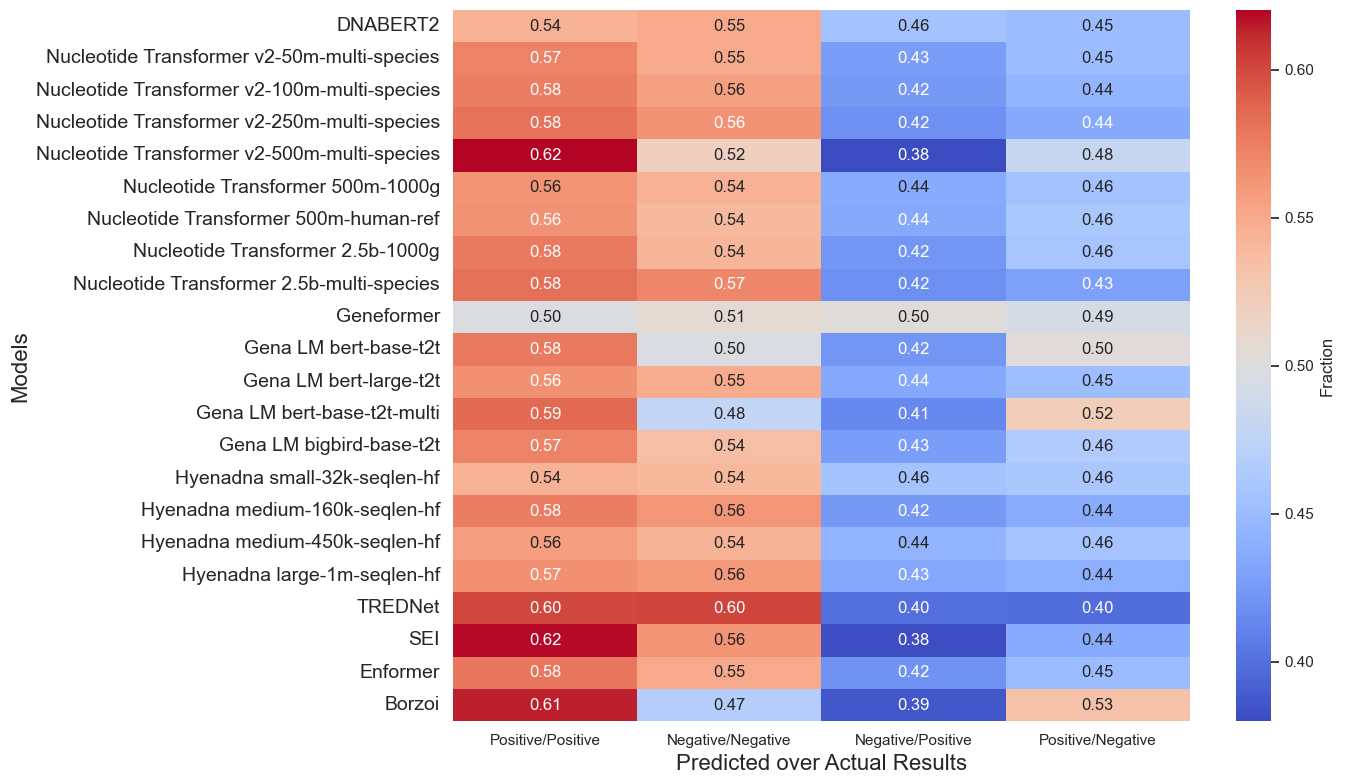

In [30]:
# Placeholder for results
results = {}

# Iterate through each model in the dictionary
for model_name, model_data in dict_all_predictions.items():
    # Extract model and experiment outputs
    first_array = model_data['data_points_clean'][0]
    second_array = model_data['data_points_clean'][1]
    
    # Define positives and negatives
    model_positive = first_array >= 0
    experiment_positive = second_array >= 0

    # Categorize cases
    positive_positive = np.sum(model_positive & experiment_positive)
    negative_negative = np.sum(~model_positive & ~experiment_positive)
    positive_negative = np.sum(model_positive & ~experiment_positive)
    negative_positive = np.sum(~model_positive & experiment_positive)

    # Total number of data points
    total_p = experiment_positive.sum()
    total_n = (~experiment_positive).sum()
    # Store fractions
    results[model_name] = {
        "Positive/Positive": positive_positive / total_p,
        "Negative/Negative": negative_negative / total_n,
        "Negative/Positive": negative_positive / total_p,
        "Positive/Negative": positive_negative / total_n,
    }

# Convert results to a DataFrame
results_df = pd.DataFrame(results).T  # Transpose to have models as rows

# Ensure y_labels matches the order of models in results_df
y_labels = [architecture_mapping_models[model] for model in results_df.index]

# Plot heatmap
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(
    results_df,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={'label': 'Fraction'},
    ax=ax,
)

# Set correct y-ticks and labels
ax.set_yticks(np.arange(len(y_labels)) + 0.5)  # Adjust tick positions
ax.set_yticklabels(y_labels, fontsize=14)



plt.ylabel('Models', fontsize=16)
plt.xlabel('Predicted over Actual Results', fontsize=16)


plt.tight_layout()

plt.savefig('figure2.png', dpi=300)

plt.show()

In [31]:
for lab in y_labels:
    print(lab)

DNABERT2
Nucleotide Transformer v2-50m-multi-species
Nucleotide Transformer v2-100m-multi-species
Nucleotide Transformer v2-250m-multi-species
Nucleotide Transformer v2-500m-multi-species
Nucleotide Transformer 500m-1000g
Nucleotide Transformer 500m-human-ref
Nucleotide Transformer 2.5b-1000g
Nucleotide Transformer 2.5b-multi-species
Geneformer
Gena LM bert-base-t2t
Gena LM bert-large-t2t
Gena LM bert-base-t2t-multi
Gena LM bigbird-base-t2t
Hyenadna small-32k-seqlen-hf
Hyenadna medium-160k-seqlen-hf
Hyenadna medium-450k-seqlen-hf
Hyenadna large-1m-seqlen-hf
TREDNet
SEI
Enformer
Borzoi


### Fraction of pos/pos etc for differnt cuts based on the p-value

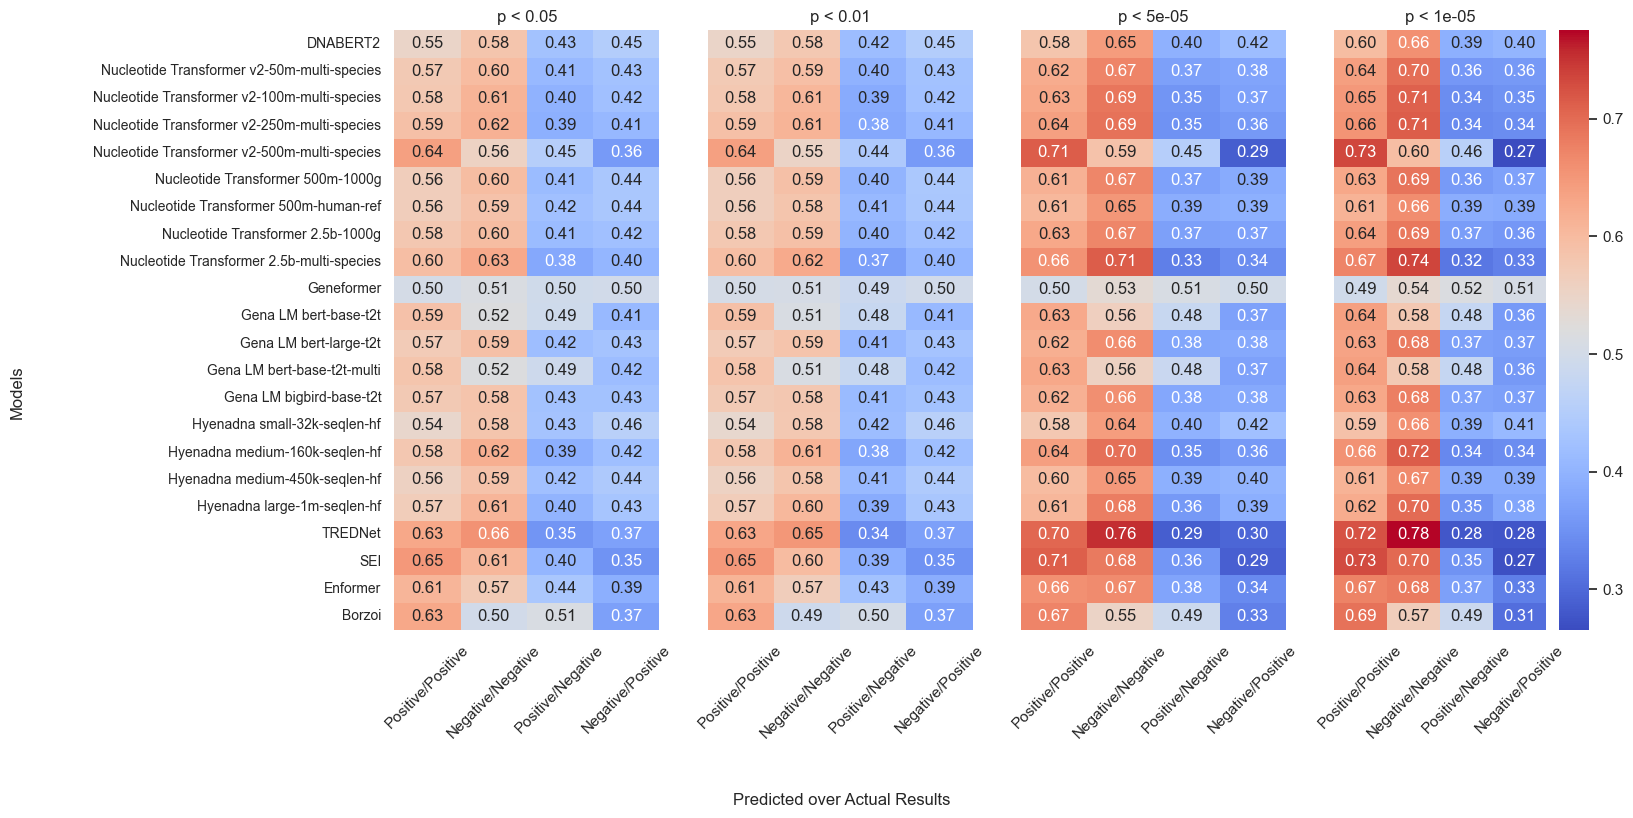

In [32]:
# Placeholder for results
results = {}

# Define thresholds for p_values
thresholds = [0.05, 0.01, 0.00005, 0.00001]

# Iterate through each model in the dictionary
for model_name, model_data in dict_all_predictions.items():
    # Extract model and experiment outputs
    first_array = model_data['data_points_clean'][0]
    second_array = model_data['data_points_clean'][1]
    p_values = model_data['p_values']  # Extract p_values

    # Initialize a dictionary to store results for this model
    results[model_name] = {}

    # Iterate through thresholds
    for threshold in thresholds:
        # Filter data points based on the threshold
        valid_indices = p_values <= threshold
        model_positive = first_array[valid_indices] >= 0
        experiment_positive = second_array[valid_indices] >= 0

        # Categorize cases
        positive_positive = np.sum(model_positive & experiment_positive)
        negative_negative = np.sum(~model_positive & ~experiment_positive)
        positive_negative = np.sum(model_positive & ~experiment_positive)
        negative_positive = np.sum(~model_positive & experiment_positive)

        # Total number of data points
        total = experiment_positive.sum()

        # Store fractions under this threshold
        results[model_name][f"p < {threshold}"] = {
            "Positive/Positive": positive_positive / total if total > 0 else 0,
            "Negative/Negative": negative_negative / total if total > 0 else 0,
            "Positive/Negative": positive_negative / total if total > 0 else 0,
            "Negative/Positive": negative_positive / total if total > 0 else 0,
        }

# Convert results to a nested DataFrame
results_df = pd.concat(
    {model: pd.DataFrame(data).T for model, data in results.items()}, axis=0
)

# Extract model names and thresholds for labeling
model_names = results_df.index.get_level_values(0).unique()
threshold_labels = results_df.index.get_level_values(1).unique()

# Calculate global minimum and maximum for consistent color range
global_min = results_df.min().min()
global_max = results_df.max().max()

# Create a grid of heatmaps (one per threshold)
fig, axes = plt.subplots(1, len(threshold_labels), figsize=(16, 8), sharey=True)

for idx, (ax, threshold) in enumerate(zip(axes, threshold_labels)):
    # Extract data for this threshold
    threshold_data = results_df.xs(threshold, level=1)

    # Add the color bar only for the last plot
    cbar_kws = {'label': 'Fraction'} if idx == len(threshold_labels) - 1 else False

    # Plot heatmap with global color range
    sns.heatmap(
        threshold_data,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=global_min,
        vmax=global_max,
        cbar=cbar_kws,
        ax=ax,
    )

    # Set titles and labels
    ax.set_title(f"{threshold}")
    ax.set_xticklabels(threshold_data.columns, rotation=45)
    ax.set_yticks(np.arange(len(model_names)) + 0.5)
    ax.set_yticklabels(
        [architecture_mapping_models[model] for model in model_names], fontsize=10
    )

# Add overall labels
fig.supxlabel('Predicted over Actual Results', y=-0.02, fontsize=12)
fig.supylabel('Models', x=-0.02, fontsize=12)

plt.tight_layout()
plt.show()


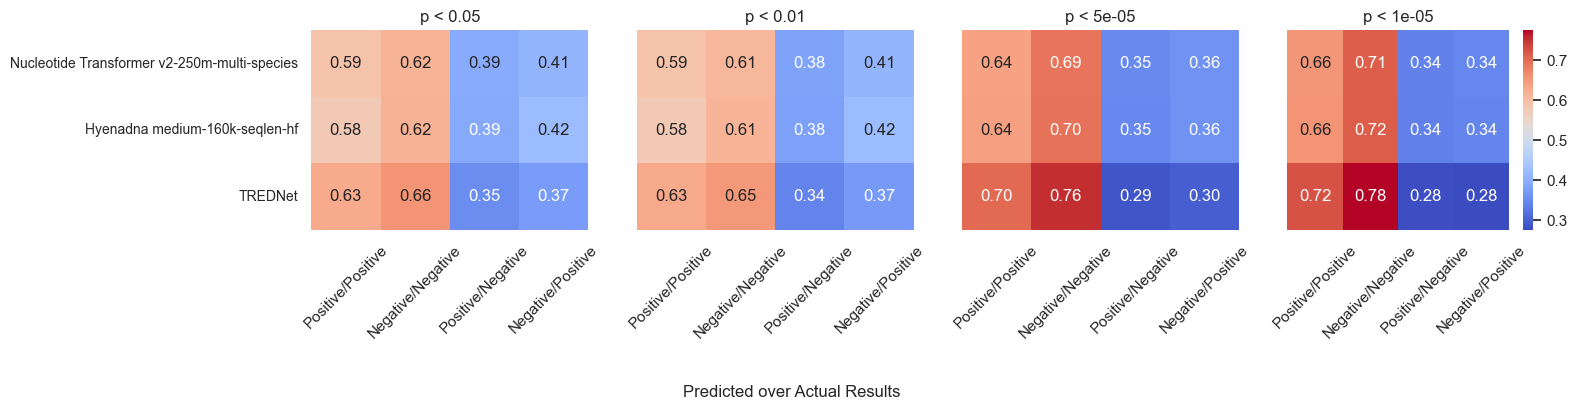

In [33]:
# Placeholder for results
results = {}

# Define thresholds for p_values
thresholds = [0.05, 0.01, 0.00005, 0.00001]

# Specify models of interest
selected_models = [
    "trednet",
    "hyenadna-medium-160k-seqlen-hf",
    "nucleotide-transformer-v2-250m-multi-species",
]

# Iterate through each model in the dictionary
for model_name, model_data in dict_all_predictions.items():
    if model_name not in selected_models:
        continue  # Skip models not in the list

    # Extract model and experiment outputs
    first_array = model_data['data_points_clean'][0]
    second_array = model_data['data_points_clean'][1]
    p_values = model_data['p_values']  # Extract p_values

    # Initialize a dictionary to store results for this model
    results[model_name] = {}

    # Iterate through thresholds
    for threshold in thresholds:
        # Filter data points based on the threshold
        valid_indices = p_values <= threshold
        model_positive = first_array[valid_indices] >= 0
        experiment_positive = second_array[valid_indices] >= 0

        # Categorize cases
        positive_positive = np.sum(model_positive & experiment_positive)
        negative_negative = np.sum(~model_positive & ~experiment_positive)
        positive_negative = np.sum(model_positive & ~experiment_positive)
        negative_positive = np.sum(~model_positive & experiment_positive)

        # Total number of data points
        total = experiment_positive.sum()  # Only count valid indices

        # Store fractions under this threshold
        results[model_name][f"p < {threshold}"] = {
            "Positive/Positive": positive_positive / total if total > 0 else 0,
            "Negative/Negative": negative_negative / total if total > 0 else 0,
            "Positive/Negative": positive_negative / total if total > 0 else 0,
            "Negative/Positive": negative_positive / total if total > 0 else 0,
        }

# Convert results to a nested DataFrame
results_df = pd.concat(
    {model: pd.DataFrame(data).T for model, data in results.items()}, axis=0
)

# Extract model names and thresholds for labeling
model_names = results_df.index.get_level_values(0).unique()
threshold_labels = results_df.index.get_level_values(1).unique()

# Calculate global minimum and maximum for consistent color range
global_min = results_df.min().min()
global_max = results_df.max().max()

# Create a grid of heatmaps (one per threshold)
fig, axes = plt.subplots(1, len(threshold_labels), figsize=(16, 4), sharey=True)

for i, (ax, threshold) in enumerate(zip(axes, threshold_labels)):
    # Extract data for this threshold
    threshold_data = results_df.xs(threshold, level=1)

    # Plot heatmap with global color range
    sns.heatmap(
        threshold_data,
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        vmin=global_min,
        vmax=global_max,
        cbar=(i == len(threshold_labels) - 1),  # Only show the color bar for the last plot
        ax=ax,
    )

    # Set titles and labels
    ax.set_title(f"{threshold}")
    ax.set_xticklabels(threshold_data.columns, rotation=45)
    ax.set_yticks(np.arange(len(model_names)) + 0.5)
    ax.set_yticklabels(
        [architecture_mapping_models[model] for model in model_names], fontsize=10
    )

# Add overall labels
fig.supxlabel('Predicted over Actual Results', y=-0.02, fontsize=12)


plt.tight_layout()
plt.show()


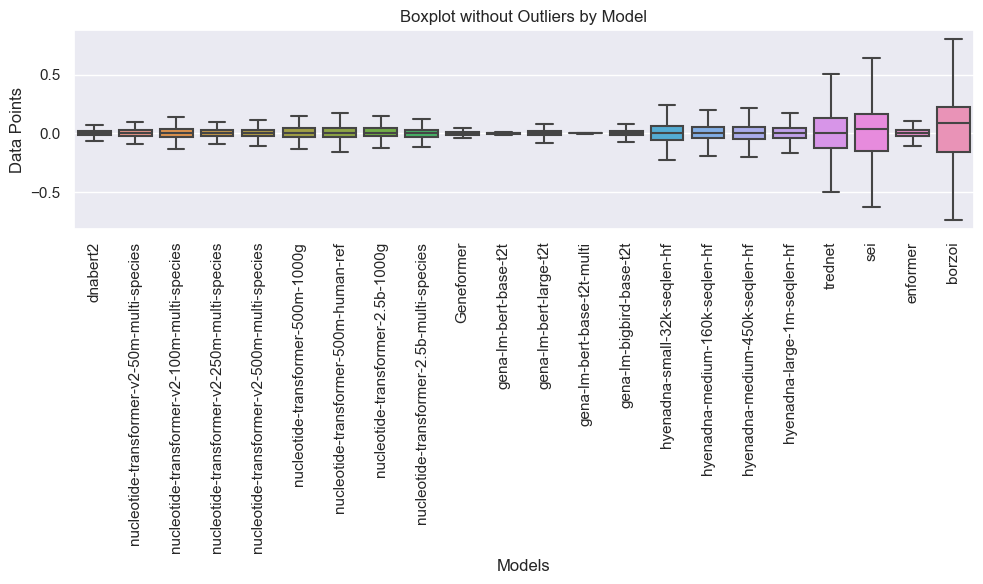

In [34]:
data = []
models = list(dict_all_predictions.keys())

# Flattening the data and associating them with their corresponding models
for model in models:
    data_points = dict_all_predictions[model]['data_points_clean'][0]  # First array of data_points
    for value in data_points:
        data.append({'Model': model, 'Data Point': value})

# Convert to pandas DataFrame for seaborn
df = pd.DataFrame(data)

# Create a boxplot for the data points without showing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Data Point', data=df, showfliers=False)

# Adding titles and labels
plt.title('Boxplot without Outliers by Model')
plt.xlabel('Models')
plt.ylabel('Data Points')

# Rotate x-axis labels if needed
plt.xticks(rotation=90)

# Show the plot
plt.tight_layout()
plt.show()

In [35]:
def process_models(dict_all_predictions):
    df_significant_data = []
    for model_name, value_dict in dict_all_predictions.items():
        # Ensure data points exist
        if model_name not in ['trednet', 'hyenadna-medium-160k-seqlen-hf', 'nucleotide-transformer-v2-250m-multi-species']:
            continue
        data_points = value_dict['data_points_clean']
        p_values = value_dict['p_values']
        
        if len(data_points) != 2 or len(p_values) == 0:
            print(f"Skipping model {model_name}: Invalid data structure.")
            continue

        # Create a dataframe for the full dataset
        df_full = pd.DataFrame({
            'Model log2 ratio': data_points[0],
            'Experiment log2 ratio': data_points[1]
        })
        
        # Prepare to collect significant dataframes and their r-values
        
        # Create a dataframe for the significant dataset

        # Filtering significant data points based on different p-value thresholds
        #thresholds = [0.05, 0.01, 0.00005]
        
        threshold = 0.00001
       
        mask = p_values < threshold
        filtered_data_points = (data_points[0][mask], data_points[1][mask])
            

            
        # Calculate correlation values
        r_val = stats.linregress(data_points).rvalue
        r_val_sig = stats.linregress(filtered_data_points).rvalue
            
            
        
        df_significant = pd.DataFrame({
            'Model log2 ratio': filtered_data_points[0],
            'Experiment log2 ratio': filtered_data_points[1],
            'Model Name': model_name
        })
        print(model_name)
       # Store the significant dataframe and r-value with the corresponding threshold
        df_significant_data.append(df_significant)
    return df_significant_data

df_significant_data_test = process_models(dict_all_predictions)

nucleotide-transformer-v2-250m-multi-species
hyenadna-medium-160k-seqlen-hf
trednet


In [36]:
import pandas as pd

# Concatenate the three dataframes
df_concat = pd.concat([df_significant_data_test[0], df_significant_data_test[1], df_significant_data_test[2]])

# Reset the index (optional)
df_concat = df_concat.reset_index(drop=True)
df_concat

Model log2 ratio  Experiment log2 ratio  \
0              0.351197               4.477955   
1             -0.014305              -4.258335   
2             -0.041880              -3.153026   
3              0.679454               3.967905   
4             -0.017577              -4.074958   
...                 ...                    ...   
27739         -0.635591               0.286400   
27740         -0.522712              -0.590500   
27741         -0.330570              -0.476200   
27742          0.013673               1.044300   
27743          0.049483               0.580700   

                                         Model Name  
0      nucleotide-transformer-v2-250m-multi-species  
1      nucleotide-transformer-v2-250m-multi-species  
2      nucleotide-transformer-v2-250m-multi-species  
3      nucleotide-transformer-v2-250m-multi-species  
4      nucleotide-transformer-v2-250m-multi-species  
...                                             ...  
27739                                       trednet  
27740                                       trednet  
27741                                       trednet  
27742                                       trednet  
27743                                       trednet  

[27744 rows x 3 columns]

In [37]:
 
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_significant_data_test[0][0] is the dataframe you want to plot
df = df_concat


/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/Dcode/gaetano/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

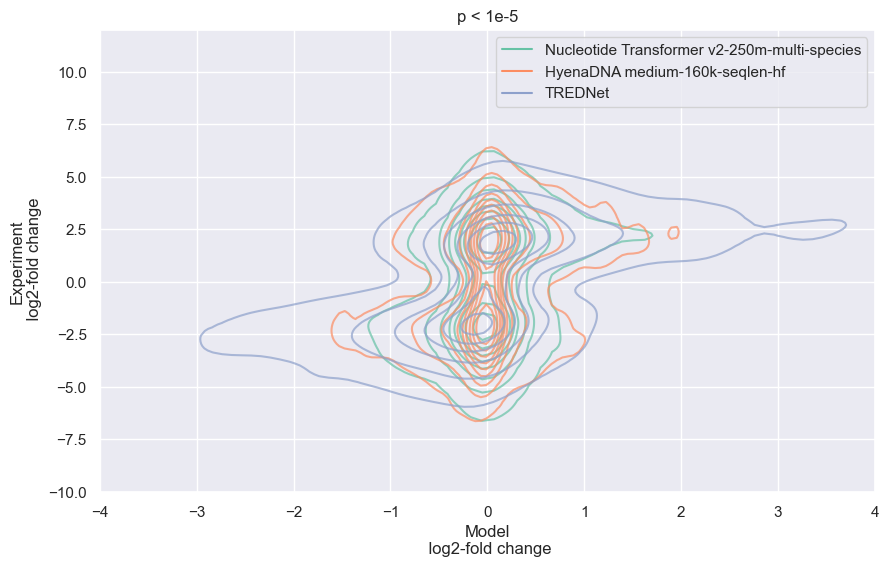

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configure visualization settings
sns.set()
plt.figure(figsize=(10, 6))
# Generate kernel density estimate (KDE) plot
g = sns.kdeplot(
    data=df,
    x='Model log2 ratio',
    y='Experiment log2 ratio',
    hue="Model Name",
    palette="Set2",
    alpha=0.7
)

# Set plot limits
plt.xlim(-4, 4)
plt.ylim(-10, 12)

# Add plot annotations

g.set_xlabel('Model\n log2-fold change')
g.set_ylabel('Experiment\n log2-fold change')

# Remove the title from the legend
g.legend_.set_title("")

legend = g.legend_
legend_labels = ["Nucleotide Transformer v2-250m-multi-species", "HyenaDNA medium-160k-seqlen-hf", "TREDNet"]  # Replace with your desired labels
for text, label in zip(legend.texts, legend_labels):
    text.set_text(label)

plt.title('p < 1e-5')


# Display plot
plt.show()


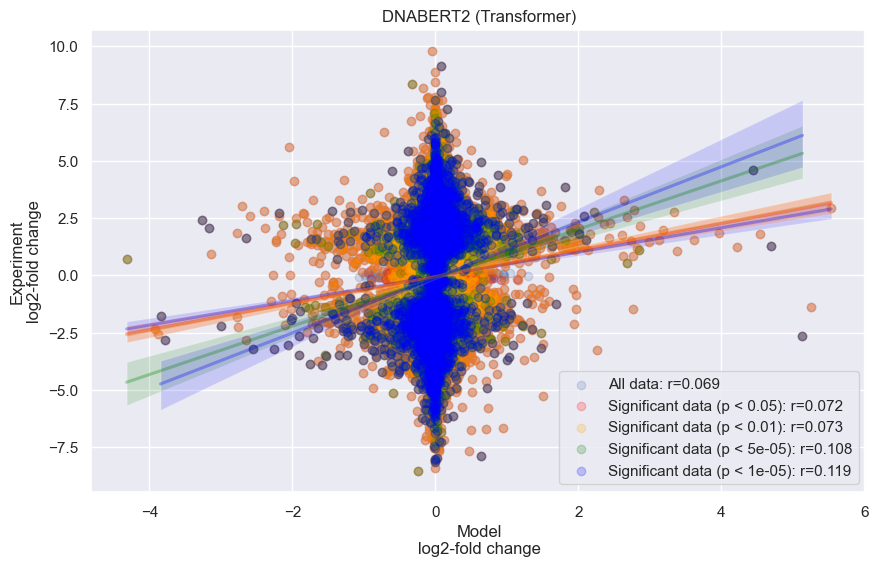

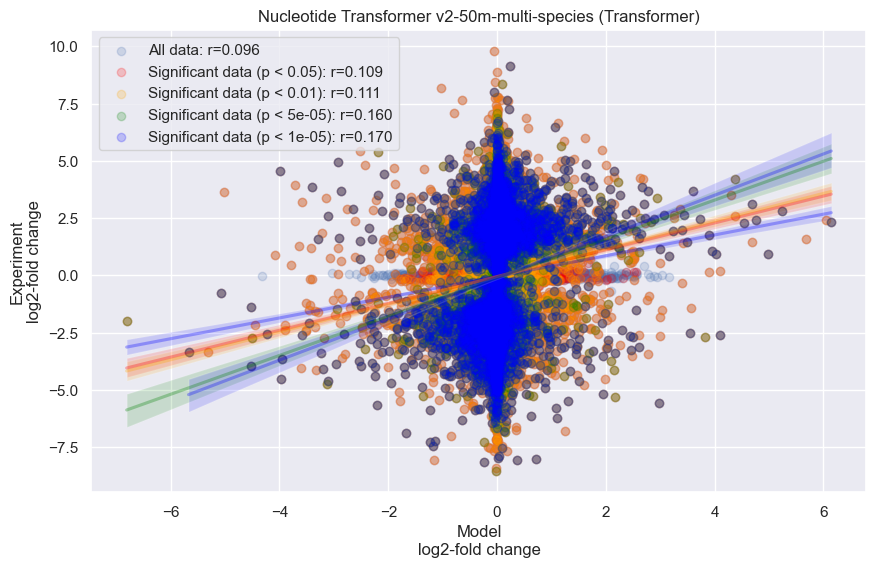

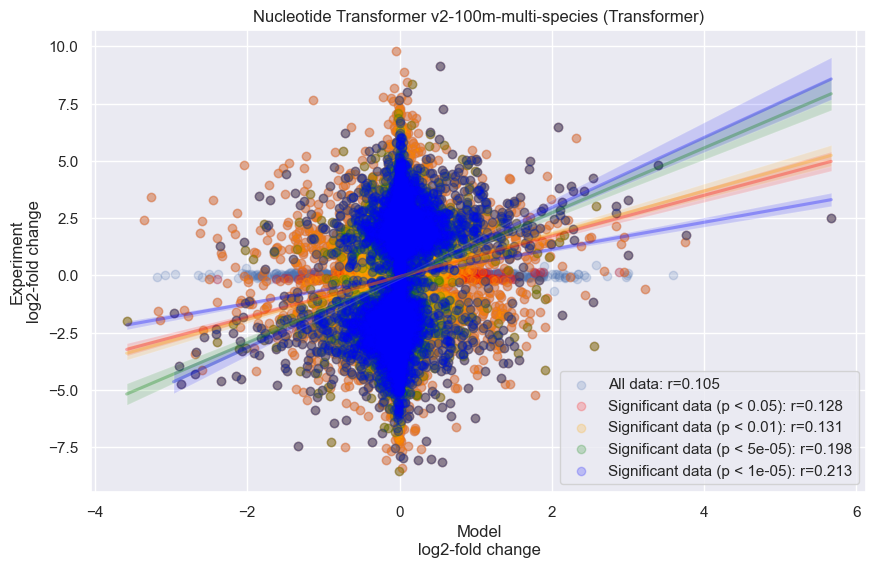

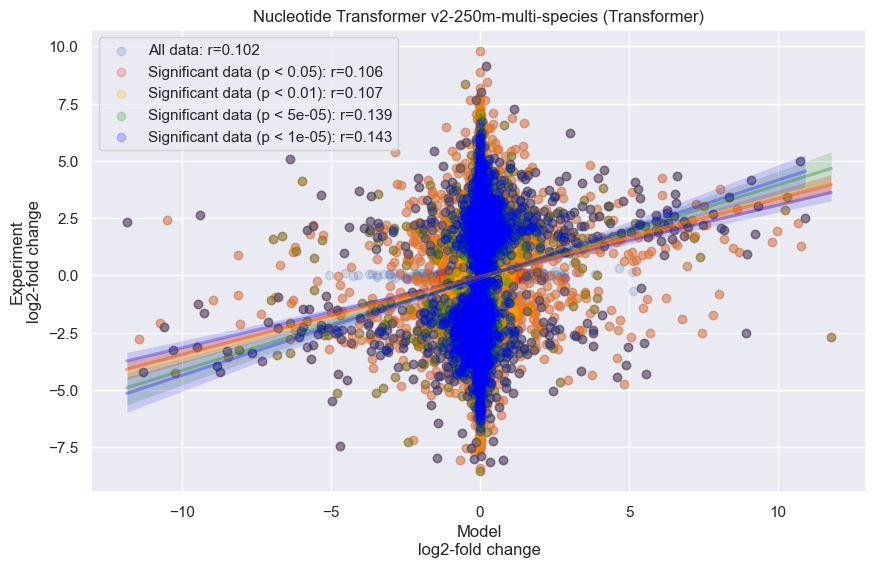

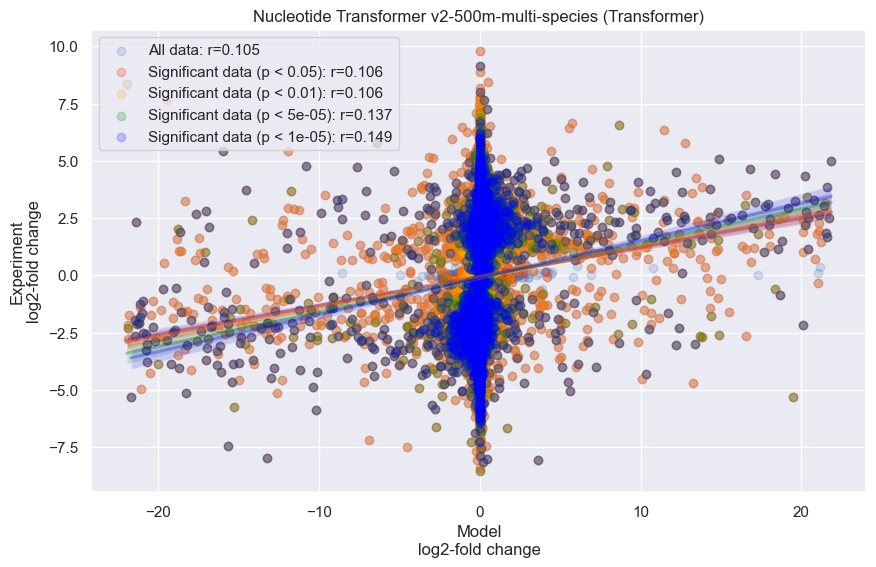

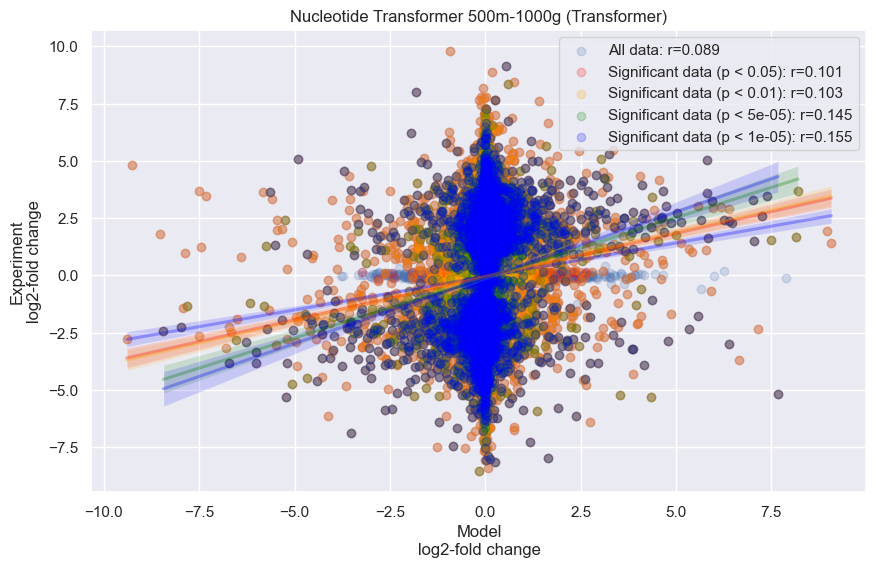

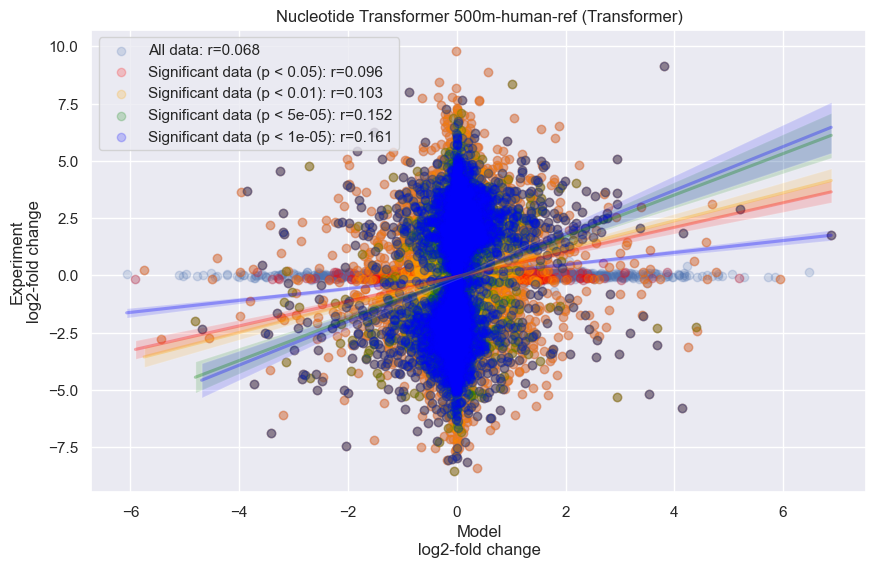

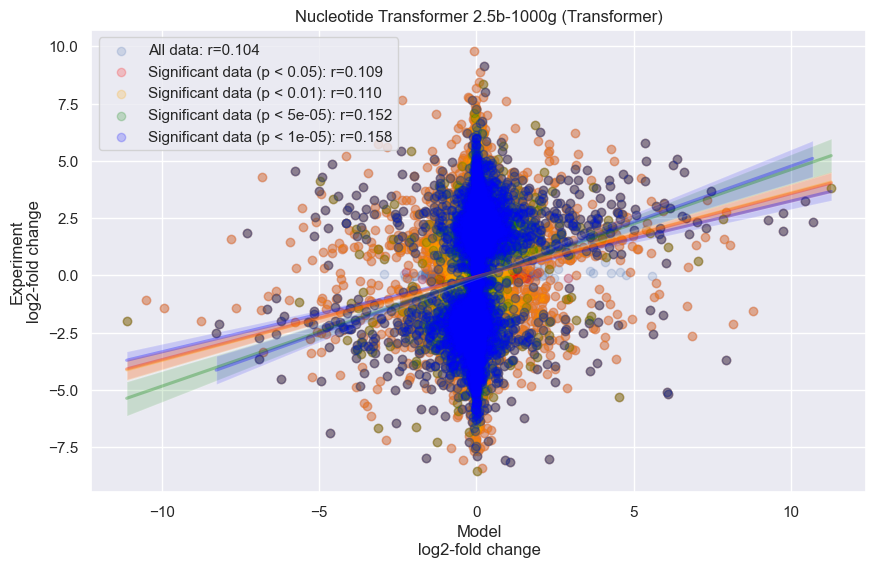

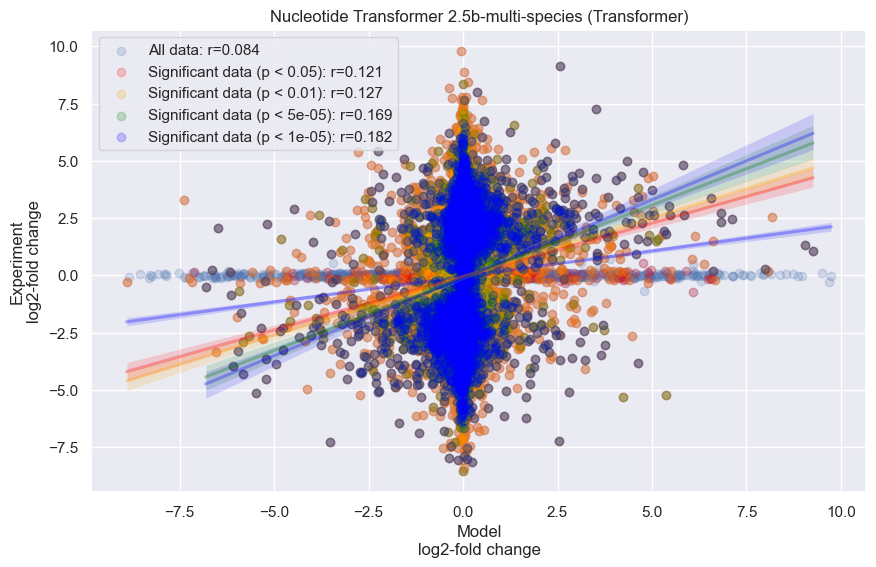

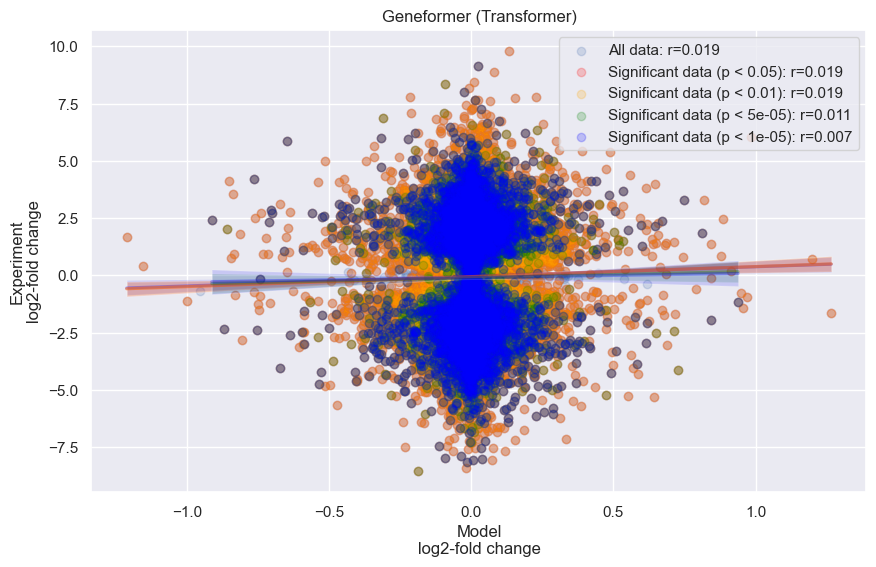

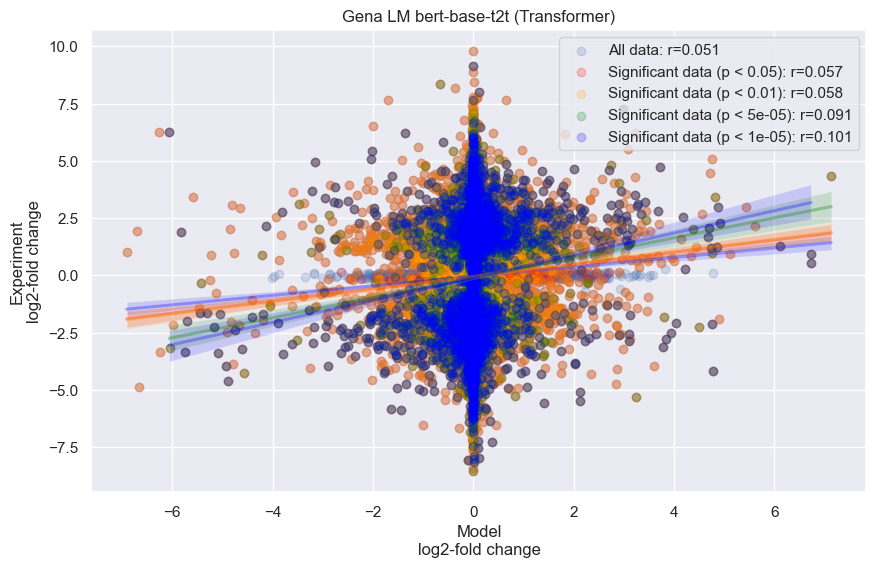

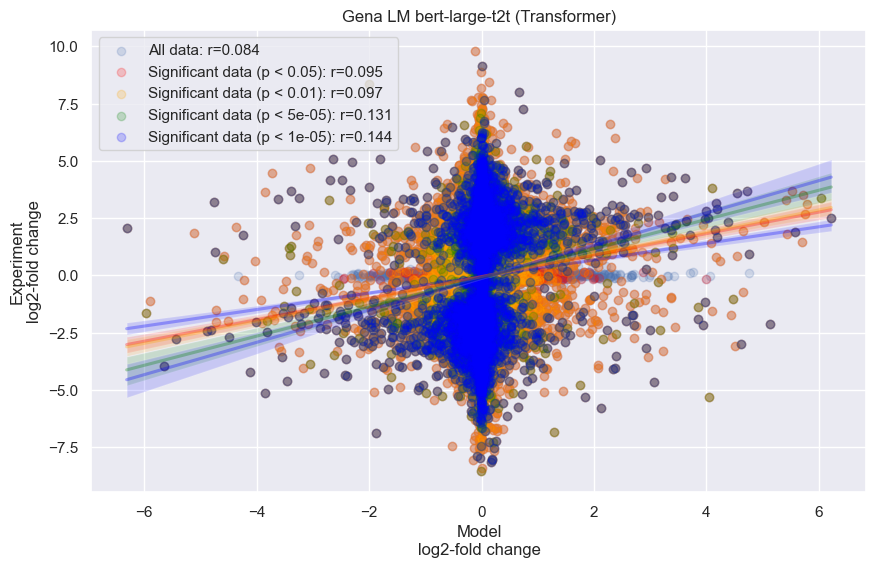

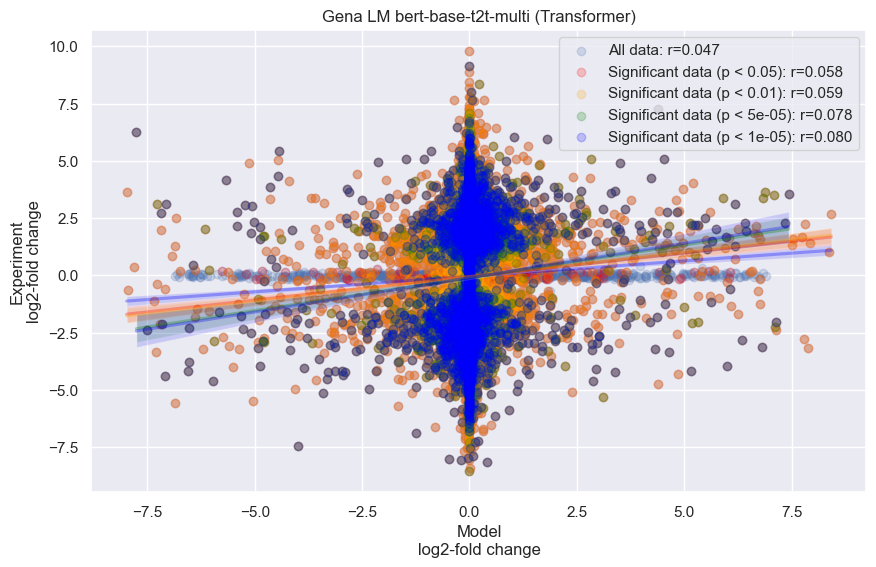

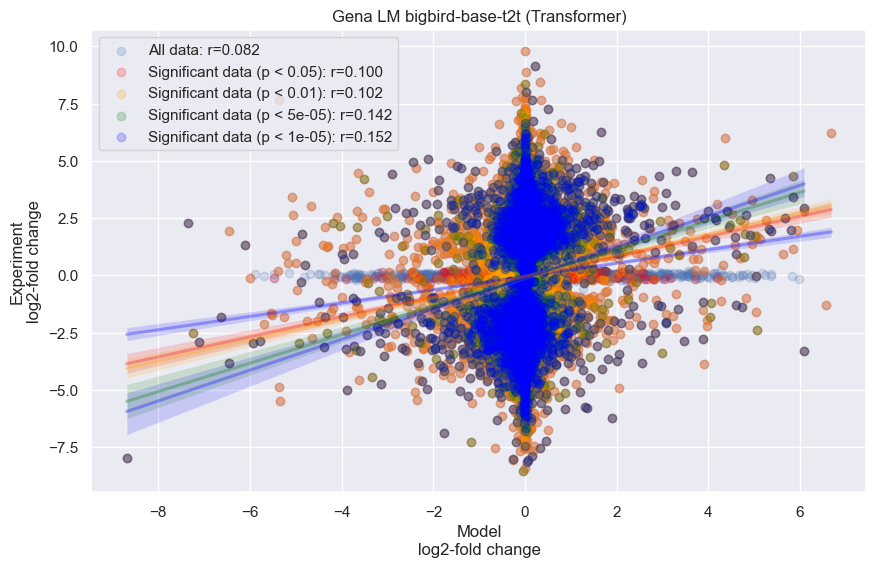

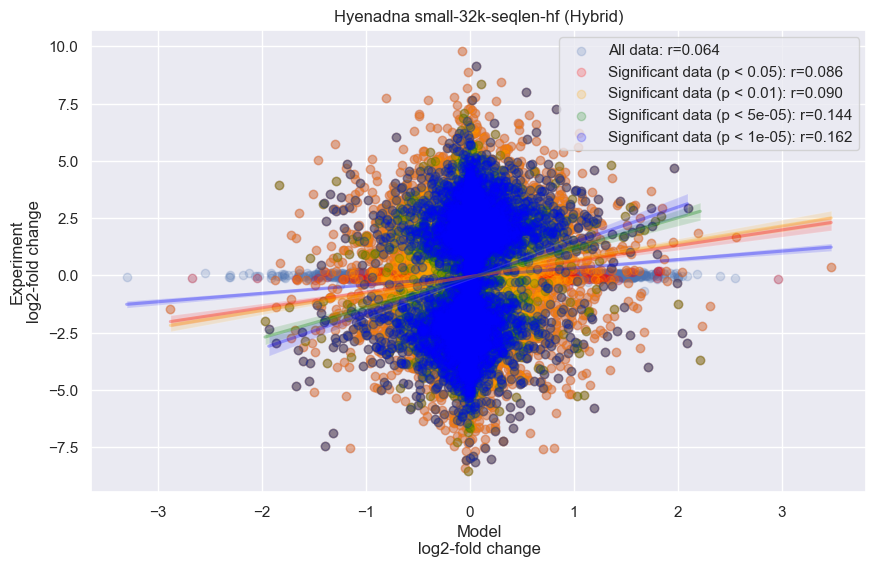

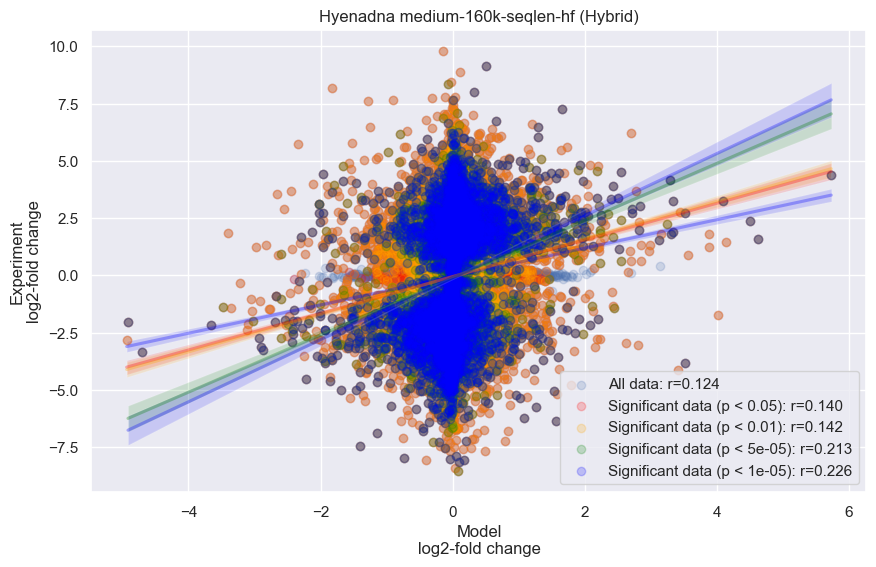

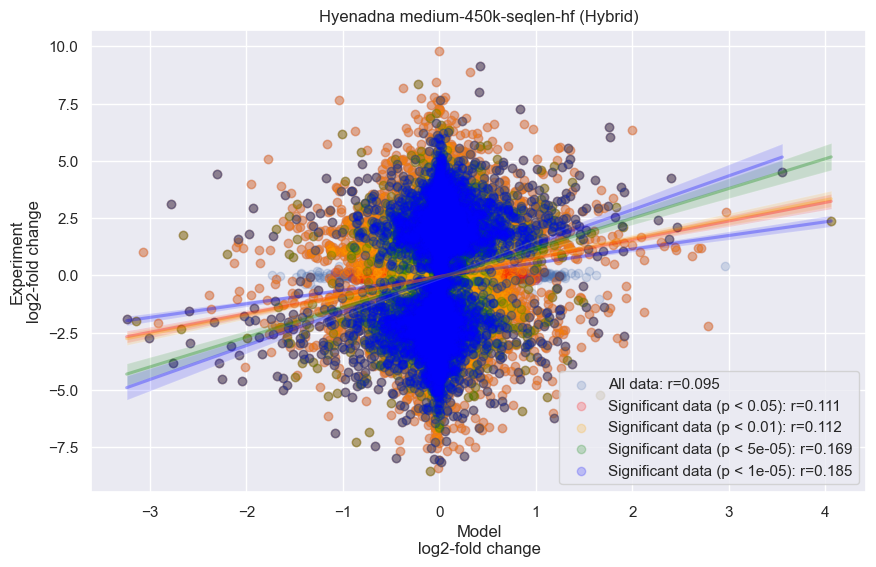

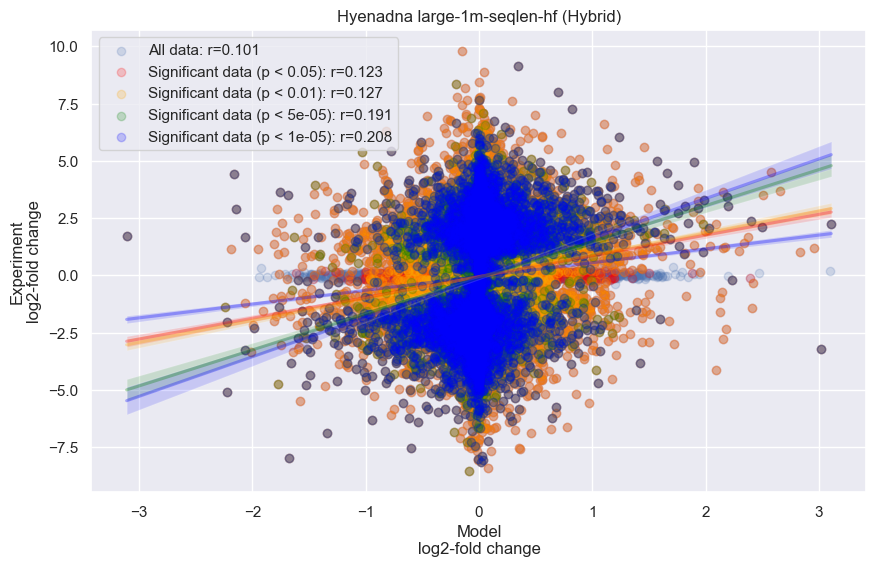

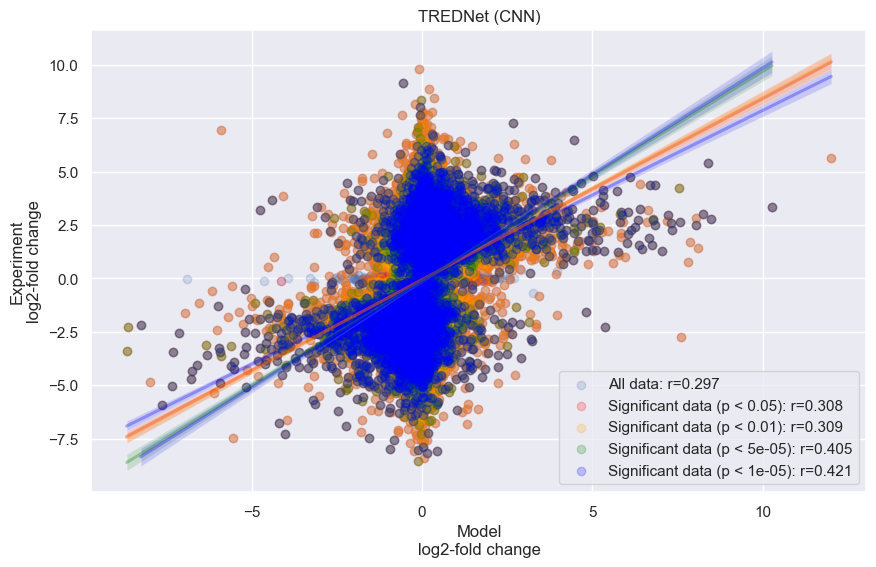

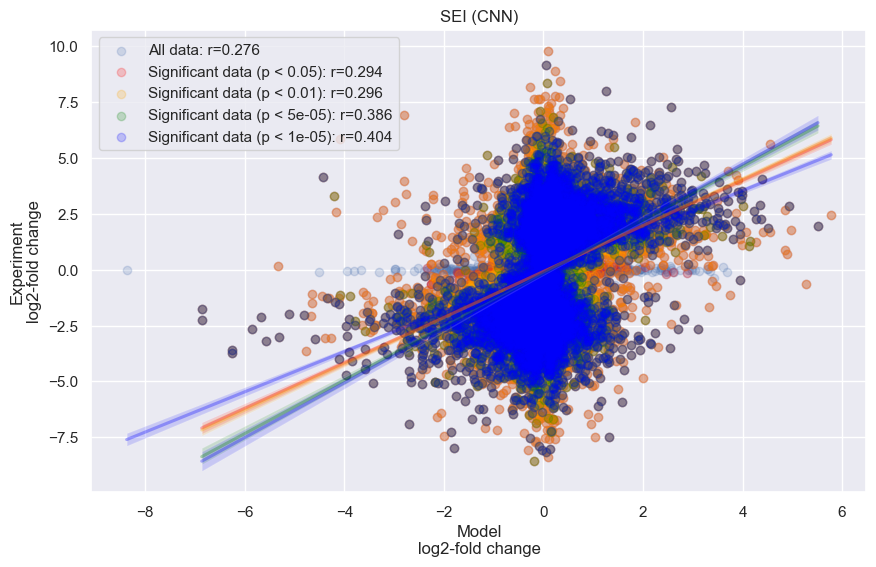

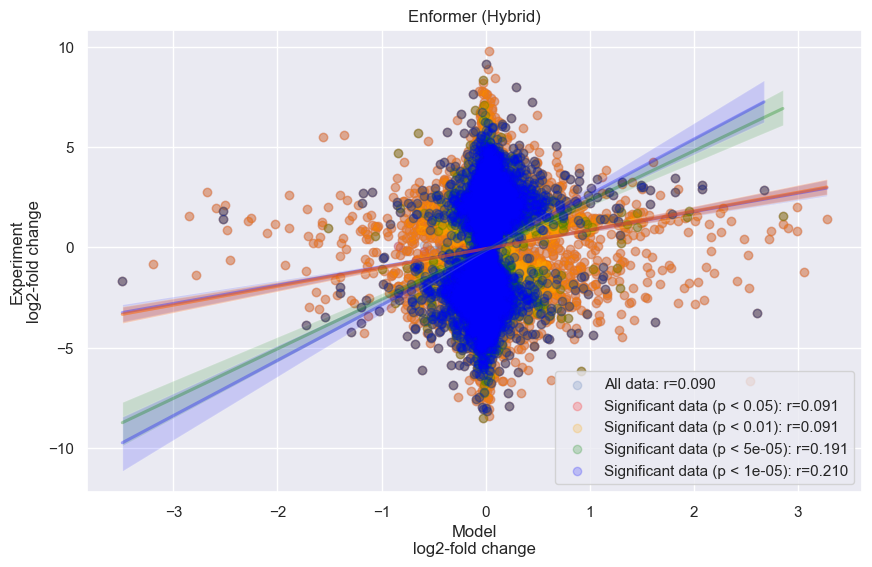

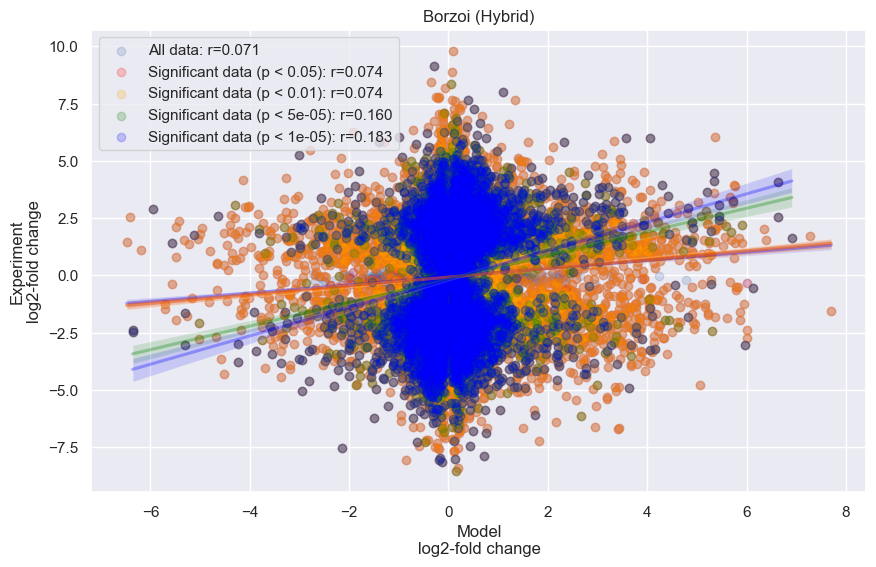

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from typing import Dict

def plot_regression(df_full, df_significant_data, model, r_val):
    plt.figure(figsize=(10, 6))
    
    # Plot for the full dataset
    sns.regplot(
        x='Model log2 ratio',
        y='Experiment log2 ratio',
        data=df_full,
        scatter_kws={'alpha': 0.2},
        line_kws={'color': 'blue', 'alpha': 0.3},
        label=f"All data: r={r_val:.3f}"
    )
    
    # Color mapping for different p-value thresholds
    color_map = {
        0.05: 'red',       # p < 0.05
        0.01: 'orange',    # p < 0.01
        0.00005: 'green',   # p < 0.00005
        0.00001: 'blue'    # p < 0.00001
    }
    
    # Plot for each significant dataset with its p-value threshold
    for (df_sig, threshold, r_val_sig) in df_significant_data:
        line_color = color_map.get(threshold, 'black')  # Default color if threshold is not found
        sns.regplot(
            x='Model log2 ratio (significant)',
            y='Experiment log2 ratio (significant)',
            data=df_sig,
            scatter_kws={'alpha': 0.2, 'color': line_color},
            line_kws={'color': line_color, 'alpha': 0.3},
            label=f"Significant data (p < {threshold}): r={r_val_sig:.3f}"
        )
    
    plt.ylabel('Experiment\nlog2-fold change')
    plt.xlabel('Model\nlog2-fold change')
    plt.title(f'{architecture_mapping_models[model]} ({architecture_mapping[model]})')
    plt.legend()
    plt.show()

def process_models_regplot(dict_all_predictions: Dict):
    for model_name, value_dict in dict_all_predictions.items():
        # Ensure data points exist
        data_points = value_dict['data_points_clean']
        p_values = value_dict['p_values']
        
        if len(data_points) != 2 or len(p_values) == 0:
            print(f"Skipping model {model_name}: Invalid data structure.")
            continue

        # Create a dataframe for the full dataset
        df_full = pd.DataFrame({
            'Model log2 ratio': data_points[0],
            'Experiment log2 ratio': data_points[1]
        })
        
        # Prepare to collect significant dataframes and their r-values
        df_significant_data = []
        
        # Filtering significant data points based on different p-value thresholds
        thresholds = [0.05, 0.01, 0.00005, 0.00001]
        for threshold in thresholds:
            mask = p_values < threshold
            filtered_data_points = (data_points[0][mask], data_points[1][mask])
            
            # Create a dataframe for the significant dataset
            df_significant = pd.DataFrame({
                'Model log2 ratio (significant)': filtered_data_points[0],
                'Experiment log2 ratio (significant)': filtered_data_points[1]
            })
            
            # Calculate correlation values
            r_val = stats.linregress(data_points).rvalue
            r_val_sig = stats.linregress(filtered_data_points).rvalue
            
            # Store the significant dataframe and r-value with the corresponding threshold
            df_significant_data.append((df_significant, threshold, r_val_sig))
        
        # Plot the regression with all significant data on the same plot
        plot_regression(df_full, df_significant_data, model_name, r_val)

# Call the function to process models
process_models_regplot(dict_all_predictions)
